In [1]:
'''
Create the Network and print the details
'''

import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

import prettytable
import time
import sys
sys.setrecursionlimit(18000)

from PIL import Image
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.data import random_split

from FixCaps_modelF256 import FixCapsNet
from images_show_410 import ImageShow

import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps

T_size = 1
BatchSize = T_size

# Settings.
#sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print('device - ',device)
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 8]) 
print("cpu_count - ",os.cpu_count())
print(f'Using {nw} dataloader workers every process.')
pin_memory = True

# Create capsule network.
conv_outputs = 256 
num_primary_units = 16 
primary_unit_size = 16 * 6 * 6
output_unit_size = 16
img_size = 299
n_classes = 2
n_channels = 3
network = FixCapsNet(conv_inputs= n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     output_unit_size=output_unit_size,
                     num_classes=n_classes,
                     init_weights=False)

print('\n----------Details of the Model-----------\n')
print(network)
print('\n----------Sizes of the Model-----------\n')

total_params = sum(p.numel() for p in network.parameters())
print(f"Number of parameters: {total_params}")

total_buffers = sum(p.numel() for p in network.buffers())
print(f"Number of bufferss: {total_buffers}")

param_size = 0
for param in network.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in network.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
size_all_mb = (param_size + buffer_size) / 1024**2

print('model size: {:.3f}MB'.format(size_all_mb))



device -  cuda
cpu_count -  12
Using 0 dataloader workers every process.

----------Details of the Model-----------

FixCapsNet(
  (Convolution): Sequential(
    (0): Conv2d(3, 3, kernel_size=(31, 31), stride=(2, 2), groups=3)
    (1): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): FractionalMaxPool2d()
  )
  (CBAM): Conv_CBAM(
    (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): Hardswish()
    (ca): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (fc1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu1): ReLU(inplace=True)
      (fc2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (sigmoid): Sigmoid()
    )

In [2]:
'''
Define the helper functions and test images directory
'''
if (device == 'cuda'):
    torch.cuda.memory.empty_cache()

network = network.to(device)
image_path = '../Test_Images'

#defined 
try:
    print('Length of test results buffers',len(test_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
    custom_path = ''

#activate ImageShow
show = ImageShow(train_loss_list=train_loss_list,
                train_acc_list=train_acc_list,
                test_loss_list=test_loss_list,
                test_acc_list=test_acc_list,
                test_auc_list=test_auc_list,
                val_loss_list=val_loss_list,
                val_acc_list=val_acc_list,
                custom_path=custom_path,
                )
data_transform = {
    "train": transforms.Compose([transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),    
    "val": transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
    "test": transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    }
test_dataset = datasets.ImageFolder(root=os.path.join(image_path),
                                      transform=data_transform["test"])

img_sample = Image.open(test_dataset.imgs[1][0])
n_channels = np.array(img_sample).shape[2]#(H,W,C)
print("n channels = ",n_channels)

test_num = len(test_dataset)
print('Using test cases from path -',image_path)
print(f'Using {test_num} test cases.')

data_list = test_dataset.class_to_idx #
cla_dict = dict((val, key) for key, val in data_list.items())
n_classes  = len(data_list)
print(f'Using {n_classes} types.')



def confusion_matrix(evl_result):

    plt.style.use("seaborn")#classic
    plt.yticks(range(n_classes),cla_dict.values())
    plt.xticks(range(n_classes),cla_dict.values())  
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.imshow(evl_result,cmap=plt.cm.Wistia) #PiYG Wistia
    for i in range(len(evl_result)):
        for j in range(len(evl_result[i])):
            plt.text(j,i,int(evl_result[i][j]))

    plt.colorbar()
    plt.savefig(f"{custom_path}/Confusion Matrix.png",dpi=128)

def self_scores(opt="scores"):
    result_table = prettytable.PrettyTable()
    result_table.field_names = ['Type','Precision', 'Recall', 'F1','Accuracy']    
    accuracy = float(torch.sum(evl_result.diagonal())/torch.sum(evl_result))

    for i in range(n_classes):
        pre = float(evl_result[i][i] / torch.sum(evl_result,0)[i])#
        recal = float(evl_result[i][i] / torch.sum(evl_result,1)[i])#torch.sum(result_table[i])
        F1 = pre * recal * 2 / (pre + recal + 1e-7)
        result_table.add_row([cla_dict[i], round(pre, 4), round(recal, 3), round(F1, 3)," "])

    result_table.add_row(["Total:", " ", " ", " ",round(accuracy,4)])
    print(result_table)

# Converts batches of class indices to classes of one-hot vectors.
def to_one_hot(x, length):
    batch_size = x.size(0)
    x_one_hot = torch.zeros(batch_size, length)
    for i in range(batch_size):
        x_one_hot[i, x[i]] = 1.0
    return x_one_hot

def test():
    network.eval()
    global evl_result,evl_tmp_result, corr_pred, wrong_pred
    
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    corr_pred = 0.0
    wrong_pred = 0.0
    steps_num = len(test_loader)#len(test_loader) * T_size
    tmp_size = T_size
    print(f'\033[66m{img_title} ==> testing ...\033[0m')
    f = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            # View original image (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
            MEAN = torch.tensor([0.485, 0.456, 0.406])
            STD = torch.tensor([0.229, 0.224, 0.225])
            x = data[0] * STD[:, None, None] + MEAN[:, None, None]

            batch_idx +=1
            target_indices = target
            target_one_hot = to_one_hot(target_indices, length=n_classes)            
            data, target = Variable(data,requires_grad=True).to(device), Variable(target_one_hot,requires_grad=True).to(device)

            output = network(data)  
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
            pred = v_mag.data.max(1, keepdim=True)[1].cpu() 

            if batch_idx % steps_num == 0 and test_num % T_size != 0:
                tmp_size = test_num % T_size
            if (target_indices.numpy()[0] != pred[0][0][0].numpy()[0]):
                wrong_pred += 1
                # View original image
                plt.imshow(x.numpy().transpose(1, 2, 0))
                plt.xticks([])
                plt.yticks([]);
                plt.show()
                print("batch_idx",batch_idx,"TARGET-",cla_dict[target_indices.numpy()[0]],":CLASSIFIED-",cla_dict[pred[0][0][0].numpy()[0]])
                print('-------------------------------------------------------------------')
            else:
                corr_pred += 1
            for i in range(tmp_size):
                #pred_y = pred.numpy()  
                evl_tmp_result[target_indices[i]][pred[i]] +=1 
            
            

    
    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result)   
    evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
    accuracy = 100. * float(torch.div(diag_sum,all_sum)) 
    test_acc_list.append(accuracy)
    
    print(f"Test_Acc:\033[1;32m{round(float(accuracy),3)}%\033[0m")
    print('correct prediction',corr_pred,'wrong predictions',wrong_pred, 'accuracy',corr_pred/(corr_pred+wrong_pred)*100.0)


n channels =  3
Using test cases from path - ../Test_Images
Using 11 test cases.
Using 2 types.


In [3]:
'''
Load model
'''
model_path = './best_OPMD_2_class_e350_skf5.pth'

img_title = "OPMD_2_class_Classified" 
custom_path = './tmp'
if os.path.exists(f'{custom_path}'):
    print (f'Store for any tmp files: {custom_path}')
else:
    !mkdir -p {custom_path} #linux

network = network.to(device)
network.load_state_dict(torch.load(model_path))


Store for any tmp files: ./tmp


<All keys matched successfully>

len of test_dataset 11  batch_size 1 len of test loader 11
OPMD_2_class_Classified ==> testing ...


  0%|          | 0/11 [00:00<?, ?it/s]

Test_Acc:100.0%
correct prediction 11.0 wrong predictions 0.0 accuracy 100.0


/tmp/ipykernel_27309/3037881221.py:63: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")#classic


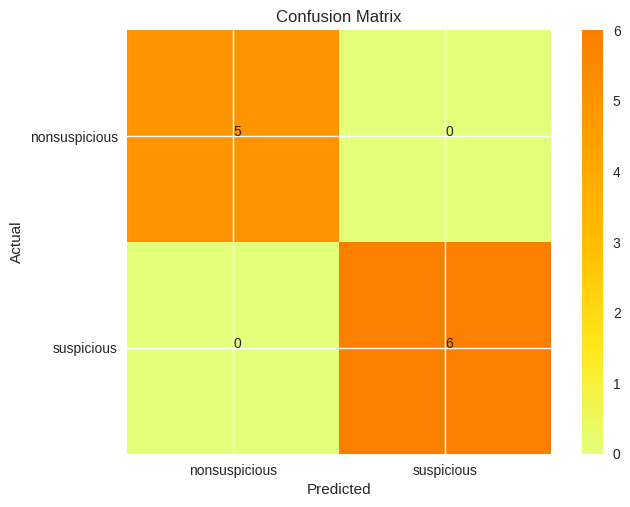

In [4]:
'''
Run tests and display results
'''
test_dataset = datasets.ImageFolder(root=os.path.join(image_path),
                                      transform=data_transform["test"])
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=T_size,
                              pin_memory=pin_memory,
                              shuffle=False, num_workers=nw)
print('len of test_dataset',len(test_dataset),' batch_size', T_size,'len of test loader',len(test_loader))

test()

confusion_matrix(evl_result)

torch.cuda.memory.empty_cache()